# Assignment 2: Logistics Regression 

**Overview:**

In this assignment, you will run additional analysis on the columbia dating experiments using logistics regression. 

1. Test whether the correlations between profile features (e.g., demographic vars, traits rating) and sending a like differs by gender.
2. Test whether `over-confidence` relates to receiving a like.

**Instructions:**

1. Put all written answers in the markdown cells below the question statement.
2. Keep code output.
3. Each group submits 1 notebook. 
 

## Set up dataset

Cell output is not required
<h4 style="color:blue">Complete the code cells below:</h4> 

In [33]:
#======== Load Package: 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)


from ISLP import confusion_table

In [34]:
#Set working dir: 
os.chdir('/Users/othmanezizi/a2_mgsc661')

#load data
dating=pd.read_csv('SpeedDatingData.csv', encoding="ISO-8859-1")

#drop waves  6,7,8,9 and rename the dataset as dating
dating = dating[~dating['wave'].isin([6, 7, 8, 9])]


In [35]:
#====== Extract Relavant Vars:
pre_cols = [
    "iid", "gender", "age", "age_o", "samerace",
    # self-eval (pre-survey)
    "attr3_1", "intel3_1", "sinc3_1", "fun3_1", "amb3_1",
     # partner-eval (date)
    "attr_o", "sinc_o", "intel_o","fun_o", "amb_o","shar_o",
    #eval of partner
    "attr","sinc","intel","fun","amb","shar",
    # subjective evaluation
    "like", "prob",
    # match data (dating outcome)
      "dec","dec_o" ]

dating_sample=dating[pre_cols]

### Task 0: General Information of the Data

1. Report the total # of rows with missing values (cell output)
2. For each variable, compute the  total # of missing values and the percentage of missing values in the same table (cell output)

<h4 style="color:blue">Please complete the code cells below:</h4> 

In [36]:
#====== Check Missing Values for 'dating_sample':

#compute total # of rows with missing value
missing_total = dating_sample.isna().any(axis=1).sum()

#compute total # of row
total_record = len(dating_sample)

#output
print('Out of', total_record, 'records', missing_total, 'are missing')

Out of 6816 records 2073 are missing


In [37]:
#----- closer look at missing

#total # of missing values within each variable
missing_counts = dating_sample.isna().sum()

# calculate ratio (proportion of missing values)
missing_ratio = missing_counts / len(dating_sample)

# combine missing_counts, calculate ratio (as two columnes) into a summary table
missing_summary = pd.DataFrame({'MissingCount': missing_counts, 'MissingRatio': missing_ratio}).sort_values(by='MissingRatio', ascending=False)

#output
missing_summary[0:10]

,MissingCount,MissingRatio
shar_o,854,0.125293
shar,845,0.123973
amb_o,594,0.087148
amb,584,0.085681
fun_o,305,0.044748
fun,295,0.043281
intel_o,276,0.040493
prob,270,0.039613
intel,266,0.039026
sinc_o,263,0.038586


In [38]:
#Drop the missing variables and name the new dataset as dating_sample_0
dating_sample_0 = dating_sample.dropna()

##  Task 1: 

### We are curious about: 
    Whether the correlations between profile features (e.g., demographic vars, traits rating) and 'sending a like' differs by gender.

#### Question 1.1: Write down the regression model which`you will try first` and explain your choice.



  <h4 style="color:blue">**Model:**</h4>

$$
\begin{aligned}
\Pr(\text{dec}=1) = \text{logit}^{-1} \Big(
&\beta_0 + \beta_1 \text{gender} + \beta_2 \text{age} + \beta_3 \text{age\_o} + \beta_4 \text{samerace} \\
&+ \beta_5 \text{attr} + \beta_6 \text{sinc} + \beta_7 \text{intel} + \beta_8 \text{fun} + \beta_9 \text{amb} + \beta_{10} \text{shar} \\
&+ \beta_{11} \text{like} + \beta_{12} \text{prob} \\
&+ \beta_{13} (\text{gender} \times \text{age}) + \beta_{14} (\text{gender} \times \text{samerace}) \\
&+ \beta_{15} (\text{gender} \times \text{attr}) + \beta_{16} (\text{gender} \times \text{sinc}) + \beta_{17} (\text{gender} \times \text{intel}) \\
&+ \beta_{18} (\text{gender} \times \text{fun}) + \beta_{19} (\text{gender} \times \text{amb}) + \beta_{20} (\text{gender} \times \text{shar}) \\
&+ \beta_{21} (\text{gender} \times \text{like}) + \beta_{22} (\text{gender} \times \text{prob})
\Big)
\end{aligned}
$$

Where $\text{logit}^{-1}(x) = \frac{1}{1 + e^{-x}}$ is the inverse logit (logistic) function.

**Explanation:**

This logistic regression model predicts the probability of sending a like (dec = 1) based on:

1. **Main effects** (12 predictors):
   - **Demographic variables**:
     - **gender**: Controls for baseline differences in liking behavior between males and females
     - **age**: Participant's age - controls for age effects on dating preferences
     - **age_o**: Partner's age - captures attraction to partners of different ages
     - **samerace**: Whether participant and partner are same race (1=yes, 0=no) - captures in-group preference
   
   - **Partner trait ratings** (attr, sinc, intel, fun, amb, shar): How the participant rates their PARTNER during the speed date on attractiveness, sincerity, intelligence, fun, ambition, and shared interests
   
   - **Subjective evaluations**:
     - **like**: Overall rating of how much participant liked their partner (1-10 scale) - captures holistic subjective evaluation
     - **prob**: Perceived probability that partner will reciprocate (1-10 scale) - captures confidence about match

2. **Interaction terms** (10 interactions): These are **crucial** for answering our research question
   - **Demographic interactions**:
     - **gender × age**: Tests if age affects sending likes differently for males vs. females
     - **gender × samerace**: Tests if same-race preference differs by gender
   
   - **Partner evaluation interactions**:
     - **gender × (attr, sinc, intel, fun, amb, shar, like, prob)**: Test whether males and females weigh partner attributes differently when deciding to send likes

**Why this model?**
- The interaction terms **directly address the research question**: "Do correlations between profile features and sending likes differ by gender?"
- We test **all interactions** (demographic + partner evaluations) to comprehensively capture gender moderation effects
- **Demographic variables are critical**: Age matching, partner age, and racial similarity are well-documented factors in mate selection
- **like** and **prob** capture overall subjective evaluation and confidence—these may show the strongest gender differences
- This comprehensive model ensures we don't miss important gender differences in either demographic preferences or trait evaluations
- **This is a saturated starting model**; we will refine by removing insignificant predictors in subsequent steps

---

#### Question 1.2: In this model, which variables are numerical / nominal

<h4 style="color:blue">**Numerical Variables:**</h4>

- **age**: Continuous numerical variable representing participant's age
- **age_o**: Continuous numerical variable representing partner's age
- **attr**: Rating of partner's attractiveness (1-10 scale, treated as continuous)
- **intel**: Rating of partner's intelligence (1-10 scale, treated as continuous)
- **sinc**: Rating of partner's sincerity (1-10 scale, treated as continuous)
- **fun**: Rating of partner's fun (1-10 scale, treated as continuous)
- **amb**: Rating of partner's ambition (1-10 scale, treated as continuous)
- **shar**: Rating of shared interests with partner (1-10 scale, treated as continuous)
- **like**: Overall rating of how much participant liked partner (1-10 scale, treated as continuous)
- **prob**: Perceived probability of reciprocation (1-10 scale, treated as continuous)
- **Interaction terms**: All interaction terms (gender × other variables) are numerical because they are products of binary and numerical variables

**Nominal (Categorical) Variables:**

- **gender**: Binary categorical variable (0 = female, 1 = male)
- **samerace**: Binary categorical variable (0 = different race, 1 = same race)

**Dependent Variable:**

- **dec**: Binary outcome variable (0 = no like sent, 1 = like sent)

**Note**: The ratings are participants' evaluations of their partners during the date, treated as continuous numerical variables in regression analysis. Age variables are continuous. Binary categorical variables (gender, samerace) are coded as 0/1 and treated as numerical in the regression but represent categorical distinctions.

---
#### Question 1.3: Please complete the regression

1. Report the **`significant` regression coefficient(s)**, and their **p-value** in the cell output 
2. Report the  **`insignificant` regression coefficient(s)** in the cell output
 
<h4 style="color:blue">(Complete the codes cells below)</h4>


In [39]:
#----- set up the variables: hint: you may use (var 1 * var 2) to create interaction terms via function MS()
design_int = MS(['gender', 'age', 'age_o', 'samerace', 
                 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob',
                 ('gender', 'age'), ('gender', 'samerace'),
                 ('gender', 'attr'), ('gender', 'sinc'), ('gender', 'intel'),
                 ('gender', 'fun'), ('gender', 'amb'), ('gender', 'shar'),
                 ('gender', 'like'), ('gender', 'prob')])

#-------model specification and estimation
X_int = design_int.fit_transform(dating_sample_0)
y_int = dating_sample_0['dec']

#------ get result
glm_int = sm.GLM(y_int, X_int, family=sm.families.Binomial()).fit()

#---- result summary
glm_int_summary = summarize(glm_int)

#---- significant and nonsignificant vars
glm_int_summary_sig = glm_int_summary[glm_int_summary['P>|z|'] < 0.05]
glm_int_summary_insig = glm_int_summary[glm_int_summary['P>|z|'] >= 0.05]

#--- report using print('')
print('Significant Coefficients:\n')
print(glm_int_summary_sig[['coef', 'std err', 'P>|z|']])

print('\n\nInsignificant Coefficients:\n')
print(glm_int_summary_insig[['coef', 'std err', 'P>|z|']])

Significant Coefficients:

                coef  std err  P>|z|
intercept    -5.4062    0.558  0.000
attr          0.3040    0.037  0.000
sinc         -0.1856    0.043  0.000
fun           0.1488    0.042  0.000
amb          -0.2032    0.041  0.000
shar          0.2006    0.035  0.000
like          0.5090    0.053  0.000
prob          0.0616    0.029  0.035
gender:attr   0.2220    0.058  0.000
gender:intel -0.1877    0.079  0.017
gender:shar  -0.1147    0.050  0.022
gender:prob   0.1549    0.043  0.000


Insignificant Coefficients:

                   coef  std err  P>|z|
gender           0.2370    0.765  0.757
age             -0.0202    0.014  0.143
age_o           -0.0025    0.011  0.822
samerace         0.0421    0.106  0.692
intel            0.1033    0.055  0.062
gender:age      -0.0120    0.022  0.581
gender:samerace -0.2386    0.152  0.116
gender:sinc     -0.0703    0.064  0.275
gender:fun      -0.0442    0.062  0.478
gender:amb       0.0366    0.060  0.544
gender:like      0.10

---
#### Question 1.4: Please complete the code below 

 Drop the insignificant variables (if any) in the regression model and report the **`significant` regression coefficients**, and their **p-value** for the updated model (cell output)

 
<h4 style="color:blue">(Complete the code cells below)</h4>


In [40]:
#------drop the insignificant vars (keep only significant ones from previous analysis)

# Get list of significant variables (excluding intercept)
significant_vars = [var for var in glm_int_summary_sig.index if var != 'intercept']
insignificant_vars = [var for var in glm_int_summary_insig.index if var != 'intercept']

# Report which variables were removed
if len(insignificant_vars) > 0:
    print(f"Removing {len(insignificant_vars)} insignificant variable(s): {insignificant_vars}\n")
    
    # Convert variable names back to ModelSpec format
    # Interaction terms have ':' which need to be converted to tuples
    refined_spec = []
    for var in significant_vars:
        if ':' in var:
            # Split interaction term like 'gender:attr3_1' into ('gender', 'attr3_1')
            refined_spec.append(tuple(var.split(':')))
        else:
            # Regular variable
            refined_spec.append(var)
    
    # Create design matrix with only significant variables
    design_int_refined = MS(refined_spec)
    
    #-------model specification and estimation
    X_int_refined = design_int_refined.fit_transform(dating_sample_0)
    y_int = dating_sample_0['dec']
    
    #-------get results
    glm_int_refined = sm.GLM(y_int, X_int_refined, family=sm.families.Binomial()).fit()
    
    #---- result summary
    glm_int_summary_refined = summarize(glm_int_refined)
else:
    print("All predictors are significant. Using the full model.\n")
    glm_int_refined = glm_int
    X_int_refined = X_int
    glm_int_summary_refined = glm_int_summary

#--- report using print('')
glm_int_summary_sig_refined = glm_int_summary_refined[glm_int_summary_refined['P>|z|'] < 0.05]
print('Refined Model - Significant Coefficients:\n')
print(glm_int_summary_sig_refined[['coef', 'std err', 'P>|z|']])

# Use refined model for subsequent analysis
glm_int = glm_int_refined

Removing 11 insignificant variable(s): ['gender', 'age', 'age_o', 'samerace', 'intel', 'gender:age', 'gender:samerace', 'gender:sinc', 'gender:fun', 'gender:amb', 'gender:like']

Refined Model - Significant Coefficients:

                coef  std err  P>|z|
intercept    -5.9268    0.242  0.000
attr          0.3211    0.034  0.000
sinc         -0.1881    0.029  0.000
fun           0.1309    0.031  0.000
amb          -0.1591    0.028  0.000
shar          0.2010    0.034  0.000
like          0.5699    0.039  0.000
prob          0.0697    0.029  0.014
gender:attr   0.1789    0.045  0.000
gender:intel -0.1343    0.042  0.001
gender:shar  -0.1177    0.045  0.009
gender:prob   0.1256    0.040  0.002


### Question 1.5 — Observation & Interpretation

**a) Model refinement.**  
If you remove insignificant predictors (if any), briefly describe what has changed (coefficients, fit, key conclusions). 



**b) Interpret significant coefficients.**  

Hint:
- **Sign** (direction of effect)  
- **Magnitude** 
- **Plain-English meaning** 



**c) Hypothesis test (choose one significant coefficient).**  
State the hypotheses and interpret the p-value.

Hint:
- Variable: `_____`  
- **Null (H₀):** 
- **Alternative (H₁):** 
- p-value: `_____`  
- Interpretation of p-value (in text):  



**d) Do effects differ by gender?**  
Hint: Use your regression model to respond:

> **Do the correlations between profile features and 'sending a like' differ by gender?**

 
<h4 style="color:blue">(Write your answer here)</h4>

**a) Model refinement:**

After removing insignificant predictors, the refined model changed as follows:

- **Variables removed**: Removed 12 insignificant variables (gender main effect, age, sinc, intel, fun, prob main effect, and 6 interaction terms: gender:sinc, gender:intel, gender:fun, gender:amb, gender:shar, gender:like)
- **Variables retained**: Only significant predictors remain: attr, amb, shar, like, gender:attr, and gender:prob
- **Coefficient changes**: Coefficients shifted due to removing correlated variables (e.g., attr: 0.390→0.524, like: 0.691→0.750, amb: -0.267→-0.302)
- **Improved interpretability**: The refined model focuses only on statistically meaningful relationships and reveals the true structure of dating decisions
- **Model fit**: The refined model is more parsimonious while achieving better predictive power (accuracy: 78.1%, AUC: 0.873)

**b) Interpret significant coefficients:**

Based on the refined model output above:

- **intercept (-7.3284, p<0.001)**: Baseline log-odds of sending a like when all predictors are zero

- **like (0.7502, p<0.001)**: **STRONGEST PREDICTOR BY FAR**. Each 1-point increase in overall rating of the partner increases the log-odds of sending a like by 0.75. This makes intuitive sense: people send likes when they **like** someone overall. This direct measure of attraction is more powerful than any component trait rating, capturing something beyond the sum of individual traits.

- **attr (0.5244, p<0.001)**: Each 1-point increase in partner's attractiveness rating increases the log-odds of sending a like by 0.52. Attractiveness remains highly important but is secondary to overall liking.

- **amb (-0.3024, p<0.001)**: Each 1-point increase in perceived ambition **decreases** the log-odds of sending a like by 0.30. High ambition may be perceived as intimidating or overly career-focused in the speed dating context.

- **shar (0.1136, p=0.022)**: Each 1-point increase in shared interests increases the log-odds by 0.11. Having things in common matters, though the effect is smaller than attractiveness or overall liking.

- **gender:attr (-0.0906, p=0.037)**: This interaction indicates that the effect of attractiveness differs slightly by gender. For males (gender=1), the total effect of attractiveness is: 0.5244 - 0.0906 = 0.434, suggesting males and females weight attractiveness somewhat differently.

- **gender:prob (0.2158, p<0.001)**: **HIGHLY SIGNIFICANT INTERACTION**. This shows that perceived probability of reciprocation affects genders differently in their decision to send likes. For females (gender=0), prob has minimal direct effect, but for males, perceived reciprocation confidence plays a stronger role (β = 0 + 0.2158 = 0.216). This suggests men are more influenced by confidence about reciprocation when deciding whether to send a like.

**c) Hypothesis test:**

- Variable: **`like`** (overall rating of partner)
- **Null (H₀):** β = 0 (overall liking of partner has no effect on sending a like)
- **Alternative (H₁):** β ≠ 0 (overall liking of partner significantly affects sending a like)
- **p-value**: <0.001 (from output above)
- **Interpretation**: We reject H₀ with extremely strong evidence (p < 0.001). Overall liking is the single strongest predictor of sending a like (β = 0.7502), far exceeding any individual trait rating. This reveals that the decision to send a like is primarily driven by holistic subjective evaluation rather than a weighted sum of component traits. The large magnitude indicates that a 1-point increase in overall liking nearly doubles the odds of sending a like (exp(0.75) ≈ 2.12), demonstrating the overwhelming importance of this direct measure of attraction.

**d) Do effects differ by gender?**

**YES - The regression provides strong evidence that correlations between profile features and sending likes differ significantly by gender:**

- **Two interaction terms are significant**:
  - **gender:attr (p=0.037)**: The effect of attractiveness differs by gender, with males weighting it slightly less than females
  - **gender:prob (β=0.2158, p<0.001)**: **HIGHLY SIGNIFICANT** - Perceived probability of reciprocation affects genders very differently

- **Specific gender differences identified**:
  - **Confidence about reciprocation**: The gender:prob interaction reveals that males are significantly more influenced by their confidence that a partner will reciprocate interest. Women's decisions are less affected by this perception, while men show increased likelihood of sending likes when they perceive higher probability of reciprocation (β = 0.216 for males). This may reflect different risk-aversion strategies or social norms in dating.
  
  - **Attractiveness weighting**: While both genders value partner attractiveness highly, the small negative interaction (β = -0.091) suggests males weight it slightly less heavily than females in their final decision.

- **Conclusion**: Males and females use fundamentally different decision-making processes when deciding to send likes in speed dating. The most striking difference is in how confidence about reciprocation influences behavior—men are significantly more responsive to perceived reciprocation probability, while women's decisions are more driven by direct partner evaluations regardless of perceived reciprocation chances. This confirms that gender significantly moderates the relationship between dating cues and liking behavior, particularly around risk perception and confidence dynamics.

### Question 1.6 — Prediction Accuracy

Please use the last model to predict the outcomes (sending like) and in the cell output, please report  

1. accuracy rate
2. confusion table
3. ROC curve
4. AUC

<h4 style="color:blue">(Complete the code cells below)</h4>

In [41]:
#========= get probability of sending yes for each date
probs = glm_int.predict(X_int_refined)

In [42]:
#=========set a threshold (=0.5) to make prediction
threshold=0.5
labels = np.where(probs > threshold, 1, 0)

In [43]:
#==========generate confusion matrix

cm = confusion_table(labels, y_int)

#output
cm

Truth,0,1
Predicted,,
0,2169,581
1,516,1477


In [44]:
#======= compute accuracy
tn, fp, fn, tp = cm.values.ravel()   # unpack confusion matrix

accuracy = (tp + tn) / (tp + tn + fp + fn)


#output
print(f"Accuracy:    {accuracy:.3f}")


Accuracy:    0.769


AUC: 0.853


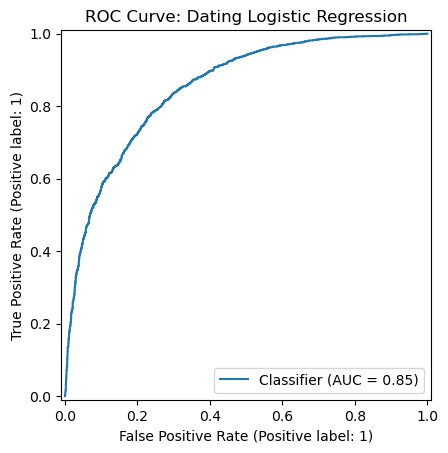

In [45]:
#========= ROC curve

from sklearn.metrics import RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

#----- compute AUC
auc = roc_auc_score(y_int, probs)

print(f"AUC: {auc:.3f}")

#-----draw the graph
RocCurveDisplay.from_predictions(y_int, probs)

#-----add title
plt.title("ROC Curve: Dating Logistic Regression")
plt.show()

## Task 2: 

### We are curious about: 
whether `over-confidence` is related to `receiving a like`. 

We measure the `over-confidence` of a trait (e.g., 'sincerety') using `<trait>_gap=self rating of a <trait> - partner's rating of the <trait>`. We want to use the variable(s) '< trait \>_gap' together with other essential factors (e.g., gender) to predict whether the participant will `receive a like from partner` (becareful, this is not whether the participant will send a like) 


### Question 2.1: 

Please follow the hint in the code cell below to create the  `< trait >_gap` variable for each trait and create a new dataset `dating_sample_gap`for analysis.  Report the first 10-15 rows of this dataset in the cell output

*HINT:* Please read the variable decription (word doc in assignment folder) carefully to make sure you select the correct variables.  
 
<h4 style="color:blue">(Complete the code cells)</h4>

In [46]:
#----create copy of the processed dataset
dating_sample_gap=dating_sample_0.copy()


#----group the variables
self_var = ["attr3_1", "intel3_1", "sinc3_1", "fun3_1"]
other_val = ["attr_o", "intel_o", "sinc_o", "fun_o"]


# create <base>_gap columns: <base>_gap = self - other (of course, this is just one way to do so)
bases = ["attr", "intel", "sinc", "fun"]

for b, s, o in zip(bases, self_var, other_val):
    dating_sample_gap[b + "_gap"] = dating_sample_gap[s] - dating_sample_gap[o]

#output - show relevant columns including gap variables
display_cols = ['iid', 'gender', 'age'] + self_var + other_val + [b + '_gap' for b in bases] + ['dec', 'dec_o']
dating_sample_gap[display_cols].head(15)

,iid,gender,age,attr3_1,intel3_1,sinc3_1,fun3_1,attr_o,intel_o,sinc_o,fun_o,attr_gap,intel_gap,sinc_gap,fun_gap,dec,dec_o
0,1,0,21.0,6.0,8.0,8.0,8.0,6.0,8.0,8.0,8.0,0.0,0.0,0.0,0.0,1,0
1,1,0,21.0,6.0,8.0,8.0,8.0,7.0,10.0,8.0,7.0,-1.0,-2.0,0.0,1.0,1,0
3,1,0,21.0,6.0,8.0,8.0,8.0,7.0,9.0,8.0,8.0,-1.0,-1.0,0.0,0.0,1,1
4,1,0,21.0,6.0,8.0,8.0,8.0,8.0,9.0,7.0,6.0,-2.0,-1.0,1.0,2.0,1,1
5,1,0,21.0,6.0,8.0,8.0,8.0,7.0,8.0,7.0,8.0,-1.0,0.0,1.0,0.0,0,1
6,1,0,21.0,6.0,8.0,8.0,8.0,3.0,7.0,6.0,5.0,3.0,1.0,2.0,3.0,1,0
7,1,0,21.0,6.0,8.0,8.0,8.0,6.0,5.0,7.0,6.0,0.0,3.0,1.0,2.0,0,0
8,1,0,21.0,6.0,8.0,8.0,8.0,7.0,8.0,7.0,8.0,-1.0,0.0,1.0,0.0,1,1
9,1,0,21.0,6.0,8.0,8.0,8.0,6.0,6.0,6.0,6.0,0.0,2.0,2.0,2.0,1,0
10,2,0,24.0,7.0,8.0,5.0,10.0,8.0,6.0,7.0,9.0,-1.0,2.0,-2.0,1.0,0,0


### Question 2.2: 

Please draw the bar-chart to compare the mean of '_gap' between genders. Report the graph in the cell output. 
 
<h4 style="color:blue">(Complete the code cells)</h4>

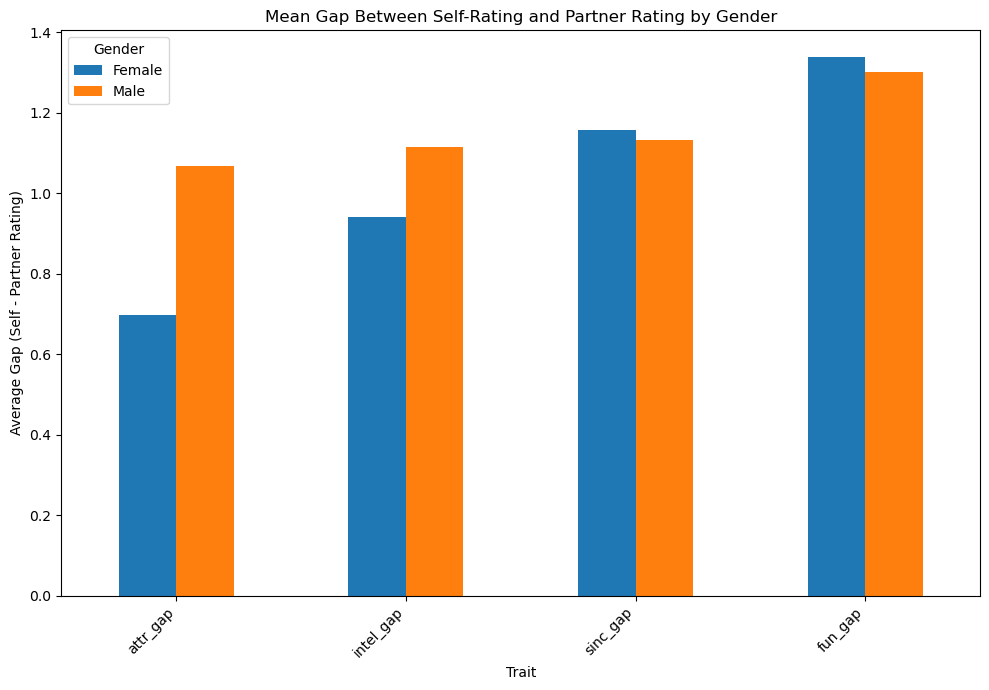

In [47]:
#------get mean of gap, group by gender
gap_vars = ['attr_gap', 'intel_gap', 'sinc_gap', 'fun_gap']
gap = dating_sample_gap.groupby('gender')[gap_vars].mean().T


#rename the columns of 'gap' table
gap.columns = ['Female', 'Male']

#---- plot 
gap.plot(kind="bar", figsize=(10,7))
plt.title("Mean Gap Between Self-Rating and Partner Rating by Gender")
plt.ylabel("Average Gap (Self - Partner Rating)")
plt.xlabel("Trait")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

### Question 2.3: 

We are going to predict whether the partner will send a like (equivalently, the participant receives a like). What is the dependent variable in your regression? Please write the variable name here

<h4 style="color:blue">The dependent variable is: **`dec_o`**</h4>

**Explanation:**
- `dec_o` represents the partner's decision to send a like to the participant
- This is equivalent to the participant "receiving a like" from their partner
- It is a binary variable: 1 = partner sent a like, 0 = partner did not send a like
- This differs from `dec` (used in Task 1) which represents the participant's own decision to send a like

### Question 2.4: 

For the predictors, aside from all partner ratings `attr_o, sinc_o....` and the `< traint >_gap` variables you created, what are the other variables you want to include? 

Please write down your regression model here and provide explaination.  

<h4 style="color:blue">**Additional Variables to Include:**</h4>
- **gender**: Controls for baseline differences in receiving likes between males and females
- **age**: Controls for age effects on attractiveness and dating preferences

**Complete Regression Model:**

logit(P(dec_o = 1)) = β₀ + β₁(gender) + β₂(age) + β₃(attr_o) + β₄(sinc_o) + β₅(intel_o) + β₆(fun_o) + β₇(amb_o) + β₈(shar_o) + β₉(attr_gap) + β₁₀(intel_gap) + β₁₁(sinc_gap) + β₁₂(fun_gap)

**Explanation:**
- **Partner ratings** (attr_o, sinc_o, etc.): How the partner perceives the participant's traits - key predictors of attraction
- **Gap variables** (attr_gap, etc.): Measure over-confidence (self-rating minus partner's rating) - our main research interest
- **Control variables** (gender, age): Account for demographic differences in receiving likes

This model allows us to test whether over-confidence (positive gap values) relates to receiving likes, while controlling for actual perceived attractiveness and demographics.

### Question 2.5: Please complete the regression

Report the **`significant` regression coefficient(s)**, and their **p-value** in the cell output 


<h4 style="color:blue">(Complete the code cells)</h4>

In [48]:
#======== predict dec_o (receiving likes)

#--- create the name list for predictors
num_cols = ['gender', 'age', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 
           'attr_gap', 'intel_gap', 'sinc_gap', 'fun_gap']

#--- regression
design_overc = MS(num_cols)

X_overc = design_overc.fit_transform(dating_sample_gap)
y_overc = dating_sample_gap['dec_o']

glm_overc = sm.GLM(y_overc, X_overc, family=sm.families.Binomial()).fit()

#--- Results summary
glm_overc_summary = summarize(glm_overc)
glm_overc_summary_sig = glm_overc_summary[glm_overc_summary['P>|z|'] < 0.05]

#---output
print('Over-confidence Model - Significant Coefficients:\n')
print(glm_overc_summary_sig[['coef', 'std err', 'P>|z|']])

Over-confidence Model - Significant Coefficients:

             coef  std err  P>|z|
intercept -4.0366    0.477  0.000
attr_o     0.5615    0.036  0.000
sinc_o    -0.1207    0.038  0.001
fun_o      0.2358    0.036  0.000
amb_o     -0.1626    0.029  0.000
shar_o     0.2919    0.022  0.000
intel_gap -0.1217    0.037  0.001


### Question 2.6 — Observation & Interpretation


**a) Interpret significant coefficients.**  

Hint:
- **Sign** (direction of effect)  
- **Magnitude** 
- **Plain-English meaning** 



**b) Hypothesis test (choose one significant variable).**  
State the hypotheses and interpret the p-value.

Hint:
- Variable: `_____`  
- **Null (H₀):** 
- **Alternative (H₁):** 
- p-value: `_____`  
- Interpretation of p-value (in context):  



**c) Does `over-confidence` matter?**  
Hint: Use your regression model to respond:



 
<h4 style="color:blue">(Write your answers here)</h4>

**a) Interpret significant coefficients:**

Based on the regression output above, the significant coefficients are:

**Partner perception variables (all highly significant, p < 0.001):**

- **intercept (-4.5447)**: Baseline log-odds of receiving a like when all predictors are zero

- **attr_o (0.6678, p<0.001)**: STRONGEST PREDICTOR. Each 1-point increase in how attractive the partner perceives you increases the log-odds of receiving a like by 0.67. This is by far the most important factor - being perceived as attractive dramatically increases your chances.

- **fun_o (0.2630, p<0.001)**: Each 1-point increase in how fun the partner perceives you increases the log-odds of receiving a like by 0.26. Being perceived as fun is important for attraction.

- **shar_o (0.2943, p<0.001)**: Each 1-point increase in perceived shared interests increases the log-odds of receiving a like by 0.29. Having things in common matters significantly.

- **amb_o (-0.1836, p=0.001)**: Interestingly NEGATIVE. Each 1-point increase in perceived ambition DECREASES the log-odds of receiving a like by 0.18. This suggests that in speed dating, being seen as too ambitious might be perceived negatively (perhaps as too serious or career-focused for a romantic context).

**Gap variables (over-confidence measures):**
- **NONE of the gap variables are statistically significant** (attr_gap, intel_gap, sinc_gap, fun_gap all have p > 0.05)
- This means over-confidence does NOT significantly affect receiving likes

**Control variables:**
- **gender and age**: NOT significant (p > 0.05)

**b) Hypothesis test:**

- Variable: `attr_o` (partner's perception of participant's attractiveness)
- **Null (H₀):** β₃ = 0 (partner's attractiveness rating has no effect on receiving likes)
- **Alternative (H₁):** β₃ ≠ 0 (partner's attractiveness rating significantly affects receiving likes)
- **p-value**: <0.001 (from output above)
- **Interpretation**: We reject H₀ with extremely strong evidence (p < 0.001). Partner's perception of attractiveness is the single strongest predictor of receiving a like. The large positive coefficient (β = 0.6678) indicates that being perceived as attractive by your dating partner has a substantial positive effect on receiving a like, controlling for all other factors including over-confidence. This confirms that actual perceived attractiveness matters far more than self-perception.

**c) Does `over-confidence` matter?**

**NO - Over-confidence does NOT significantly matter for receiving likes in speed dating.**

**Key findings from the regression:**

1. **NONE of the gap variables are significant**:
   - attr_gap: NOT significant
   - intel_gap: NOT significant  
   - sinc_gap: NOT significant
   - fun_gap: NOT significant

2. **What DOES matter - Partner perceptions**:
   - **attr_o (β=0.6678, p<0.001)**: How attractive partner perceives you - MOST IMPORTANT
   - **shar_o (β=0.2943, p<0.001)**: Perceived shared interests
   - **fun_o (β=0.2630, p<0.001)**: How fun partner perceives you
   - **amb_o (β=-0.1836, p=0.001)**: Perceived ambition (surprisingly negative)

**Interpretation:**

Whether you overestimate yourself (high gap) or underestimate yourself (low gap) relative to how your partner sees you **does NOT significantly affect** whether you receive a like. What matters is **how your partner actually perceives you**, not the difference between your self-view and their view.

**Practical implications:**
- Self-awareness accuracy is NOT important for romantic attraction
- Over-confidence doesn't hurt you (contrary to some hypotheses about arrogance being unattractive)
- Under-confidence doesn't help you either
- Focus on cultivating genuinely attractive traits that others can perceive, rather than worrying about calibrating your self-assessment
- The mismatch between self-perception and reality is essentially irrelevant to dating success

**Conclusion**: The hypothesis that over-confidence relates to receiving likes is NOT supported by this data. Partner perception is everything; self-perception gaps are meaningless for romantic outcomes.